In [1]:
import sys
import os

from typing import Tuple, Dict
import warnings
import time

import numpy as np

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
# add module
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from translators.utils.constants import Constants
from translators.datasets.translation_dataset import TranslationDataset

from translators.networks.encoder import Encoder
from translators.networks.decoder import Decoder

In [4]:
# device
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# dataset
dataset = TranslationDataset("de_core_news_sm", "en_core_web_sm")
train_loader, (source_vocab, target_vocab) = dataset.load("train", 32, current_device)
len(source_vocab), len(target_vocab)

(19215, 10838)

In [6]:
# special tokens
source_vocab.get_itos()[:4], target_vocab.get_itos()[:4]

(['<unk>', '<pad>', '<bos>', '<eos>'], ['<unk>', '<pad>', '<bos>', '<eos>'])

In [8]:
bos_tok_id = source_vocab.get_stoi()[Constants.SPECIAL_TOKEN_BOS]

In [9]:
for i, (s, t) in enumerate(train_loader):
    source_sample, target_sample = s, t
    break

In [10]:
def plot_network_layer(layer_name: str, layer_output: torch.Tensor):
    # setup
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={
        "grid.linewidth": 0.2, 
        "axes.titlesize": 8,
        "axes.labelsize": 8
    })

    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

    # plt
    ax_0 = ax if not hasattr(ax, '__iter__') else ax[0]
    ax_0.set_title(layer_name)
    sns.kdeplot(data=layer_output.flatten().detach().numpy(), color="darkblue", fill=False, ax=ax_0, linewidth=1)

    # display
    plt.tight_layout()
    plt.show()
    pass

In [11]:
# encoder configs
enc_embedding_dim = 256
enc_lstm_layers = 4
enc_lstm_hidden_dim = 256
enc_bidirec = True
enc_dropout_p = 0.025

# decoder configs
dec_embedding_dim = 256

# init encoder
enc = Encoder(
    vocab_size=len(source_vocab.get_itos()),
    embedding_dim=enc_embedding_dim, 
    lstm_num_layers=enc_lstm_layers, 
    lstm_hidden_dim=enc_lstm_hidden_dim, 
    lstm_bidirec=enc_bidirec, 
    dropout_p=enc_dropout_p
)

# init decoder
dec = Decoder(
    vocab_size=len(target_vocab.get_itos()),
    embedding_dim=dec_embedding_dim,
    enc_lstm_hidden_dim=enc_lstm_hidden_dim,
    enc_lstm_bidirec=enc_bidirec,
    enc_lstm_layers=enc_lstm_layers,
    bos_tok_id=source_vocab.get_stoi()[Constants.SPECIAL_TOKEN_BOS],
    use_stepwise_ctxt=True
)

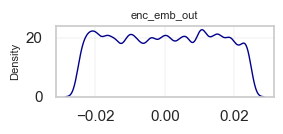

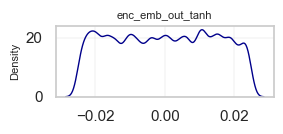

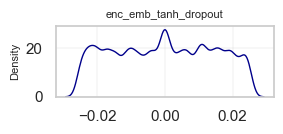

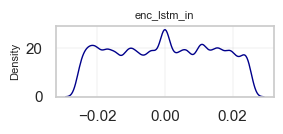

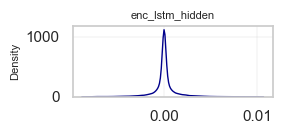

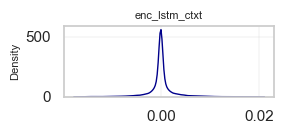

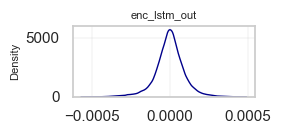

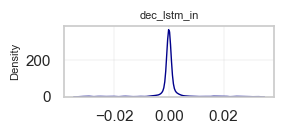

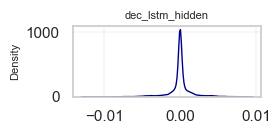

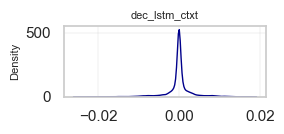

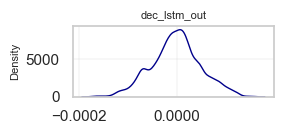

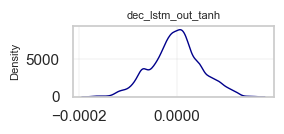

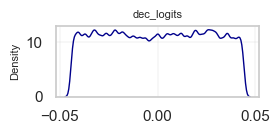

In [13]:
# encoder layers
for l_name in list(enc_layer_outputs.keys()):
    l_out = enc_layer_outputs[l_name]
    plot_network_layer(f"enc_{l_name}", l_out)
    pass

# decoder layers
for l_name in list(dec_layer_outputs.keys()):
    l_out = dec_layer_outputs[l_name]
    plot_network_layer(f"dec_{l_name}", l_out)
    pass

In [21]:
# training setup
torch.enable_grad()
train_loss_i = list()
train_loader, (source_vocab, target_vocab) = dataset.load("train", 256, current_device)

In [22]:
# opt / lr
enc_opt = torch.optim.AdamW(enc.parameters(), lr = 1e-3)
dec_opt = torch.optim.AdamW(dec.parameters(), lr = 1e-3)
loss_function = nn.NLLLoss()

In [26]:
# trial run
for i, batch in enumerate(train_loader):     
    b_source, b_target = batch
    
    lstm_hidden, lstm_ctxt, _ = enc(b_source)
    logits, _ = dec(lstm_hidden, lstm_ctxt, use_teacher_forcing=True, minibatch_target=b_target)
    log_probs = F.log_softmax(logits, dim=-1)

    # zero grads
    enc.zero_grad(set_to_none=True)
    dec.zero_grad(set_to_none=True)

    # loss
    loss = loss_function(
        log_probs.view(-1, log_probs.size(-1)),
        b_target.view(-1)
    )

    # backprop
    loss.backward()
    enc_opt.step()
    dec_opt.step()

    # track
    train_loss_i.append(round(loss.item(), 2))
    pass

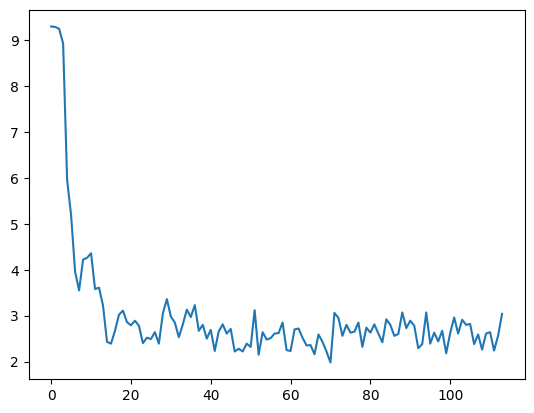

In [27]:
# plot
plt.plot(train_loss_i)